Mejoras: 
* Adaptar la arquitectura para aceptar tamaños WyH diferentes por ejemplo: 108 y 192
* Visualizar algunasi magenes reconstruidas durante el entrenamiento 

In [2]:
from monitorlib import load_pcdata
import pandas as pd

data = load_pcdata('data')

img_paths = []
for sample in data.keys():
     img_paths.extend([img_path for img_path in data[sample]['screenshots']['img_path']])
images_df = pd.DataFrame(img_paths, columns=['img_path'])
images_df

,img_path
0,data/sample1/0000000000_0.04096198081970215.jpg
1,data/sample1/0000000001_0.12202715873718262.jpg
2,data/sample1/0000000002_0.19535470008850098.jpg
3,data/sample1/0000000003_0.26665711402893066.jpg
4,data/sample1/0000000004_0.3381388187408447.jpg
...,...
4026,data/sample7/0000000497_34.36405061290134.jpg
4027,data/sample7/0000000498_34.434010161901824.jpg
4028,data/sample7/0000000499_34.50612504198216.jpg
4029,data/sample7/0000000500_34.57848913397174.jpg


In [3]:
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision import transforms
import os
from torchvision.io import read_image
from PIL import Image

class ScreenshotsDataset(Dataset):
    def __init__(self, images_df, root_dir, transform=None):
        self.images_df = images_df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.images_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = os.path.join(self.root_dir, self.images_df.iloc[idx, 0])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

IMGSIZE= [64,64] #[1080//10, 1920//10]
transform = transforms.Compose([
        transforms.Resize(IMGSIZE, antialias=None),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
        ])

batch_size = 128
dataset = ScreenshotsDataset(images_df, root_dir='./', transform=transform)
m =len(dataset)
traindata, valdata = torch.utils.data.random_split(dataset,[3631, 400])

trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=10)
valloader = torch.utils.data.DataLoader(valdata, batch_size=batch_size, shuffle=False, num_workers=10)

/home/ezamorag/miniconda3/envs/automat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


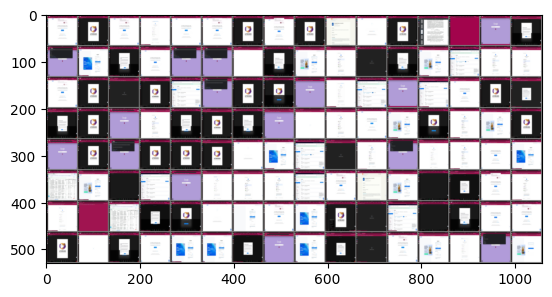

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 

def unnormalized(xtensor):
    return np.transpose((xtensor*0.5+0.5).numpy(), (1, 2, 0))

dataiter = iter(trainloader)
images = next(dataiter)
mosaic = torchvision.utils.make_grid(images, nrow = 16)
plt.imshow(unnormalized(mosaic))
plt.show()


In [5]:
def encfeaturessize():
    P = [0,0,0,0]
    S = [2,2,2,2]
    K = [4,4,4,4]
    W = [64]
    H = [192]
    for k,s,p in zip(K,S,P):
        W.append(int((W[-1] - k +2*p)/s+1))
        H.append(int((H[-1] - k +2*p)/s+1))
    print(W)
    print(H)

## AUN NO FUNCIONA
def decfeaturessize():
    P = [0,0,0,0]
    S = [2,2,2,2]
    K = [5,5,6,6]
    W = [1081]
    H = [1920]
    for k,s,p in zip(K,S,P):
        W.append(int((W[-1] - k +2*p)/s+1))
        H.append(int((H[-1] - k +2*p)/s+1))
    print(W)
    print(H)

encfeaturessize()

[64, 31, 14, 6, 2]
[192, 95, 46, 22, 10]


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,4, stride=2, padding="valid")
        self.conv2 = nn.Conv2d(32,64,4, stride=2, padding="valid")
        self.conv3 = nn.Conv2d(64,128,4, stride=2, padding="valid")
        self.conv4 = nn.Conv2d(128,256,4, stride=2, padding="valid")
        self.fc_mean = nn.Linear(256*2*2, latent_dims)
        self.fc_logvar = nn.Linear(256*2*2, latent_dims)

        self.N = torch.distributions.normal.Normal(torch.tensor(0.0).to(device), 
                                                   torch.tensor(1.0).to(device))
        self.kl = 0
    
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1)
        z_mu = self.fc_mean(x)
        z_logvar = self.fc_logvar(x)
        z_sigma = torch.exp(0.5*z_logvar)
        
        z = z_mu + z_sigma*self.N.sample(z_mu.shape)
        self.kl = 0.5*(z_sigma**2 + z_mu**2 - z_logvar - 1).sum()
        return z, z_mu, z_sigma

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 1024),
            nn.ReLU(True),
            nn.Unflatten(1,(1024,1,1)),
            nn.ConvTranspose2d(1024,128,5, stride=2, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,5, stride=2, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,32,6, stride=2, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(32,3,6, stride=2, padding=0),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.decoder(x)

class Vae(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z, _, _ = self.encoder(x)
        return self.decoder(z)

In [7]:
def train_epoch(vae, device, dataloader, optimizer):
    vae.train()
    train_loss = 0.0
    for x in dataloader: 
        x = x.to(device)
        y = vae(x)
        loss = ((x - y)**2).sum() + vae.encoder.kl
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    return train_loss/len(dataloader.dataset)

def test_epoch(vae, device, dataloader):
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): 
        for x in dataloader:
            x = x.to(device)
            y = vae(x)
            loss = ((x - y)**2).sum() + vae.encoder.kl
            val_loss += loss.item()
    return val_loss/len(dataloader.dataset)


In [8]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ezamorag (cic_lab). Use `wandb login --relogin` to force relogin


True

In [9]:
# Training from scratch
d = 32
SEED = 0
lr = 0.001
epoch0 = 0
num_epochs = 50

torch.manual_seed(SEED)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'device: {device}')
vae = Vae(latent_dims=d)
vae.to(device)
optim = torch.optim.Adam(vae.parameters(), lr=lr)
best_valloss = float('Inf')
path_bestmodel = 'best_vae_tosample.pt'

device: cuda


In [10]:
from IPython.display import clear_output

run = wandb.init(project="vae-pc", 
                 #name='2000 epochs', 
                 #entity='cic20',
                 mode="disabled", 
                 config={
                    "image_size": IMGSIZE,
                    "input_transform": transform, 
                    "vae_latent_dims": d,
                    "learning_rate": lr,
                    "epochs": num_epochs,
                    "batch_size": trainloader.batch_size,
                    "seed": SEED, 
                 },
)
wandb.watch(vae, log_freq=100)

trainloss, valloss = [], []
for epoch in range(epoch0, epoch0+num_epochs):
   trainloss.append(train_epoch(vae,device,trainloader,optim))
   valloss.append(test_epoch(vae,device,valloader))
   if valloss[-1] < best_valloss: 
      best_valloss = valloss[-1]
      torch.save({'epoch': epoch,
                  'model_state_dict': vae.state_dict(),
                  'optimizer_state_dict': optim.state_dict(),
                  'trainloss': trainloss[-1],
                  'valloss': valloss[-1],},
                  path_bestmodel)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,trainloss[-1],valloss[-1]))
   #plot_ae_outputs(vae,n=10)
   clear_output(wait=True) if (epoch + 1) % 10 == 0 else None
   wandb.log({"t_loss": trainloss[-1], "v_loss": valloss[-1]})


 EPOCH 41/50 	 train loss 70.229 	 val loss 72.245

 EPOCH 42/50 	 train loss 68.840 	 val loss 73.483

 EPOCH 43/50 	 train loss 66.980 	 val loss 75.904

 EPOCH 44/50 	 train loss 66.276 	 val loss 73.850

 EPOCH 45/50 	 train loss 65.396 	 val loss 72.826

 EPOCH 46/50 	 train loss 64.099 	 val loss 71.883

 EPOCH 47/50 	 train loss 64.097 	 val loss 65.488

 EPOCH 48/50 	 train loss 62.589 	 val loss 64.807

 EPOCH 49/50 	 train loss 62.102 	 val loss 73.633

 EPOCH 50/50 	 train loss 61.733 	 val loss 65.553


best val_loss = 64.80685119628906 at epoch = 47


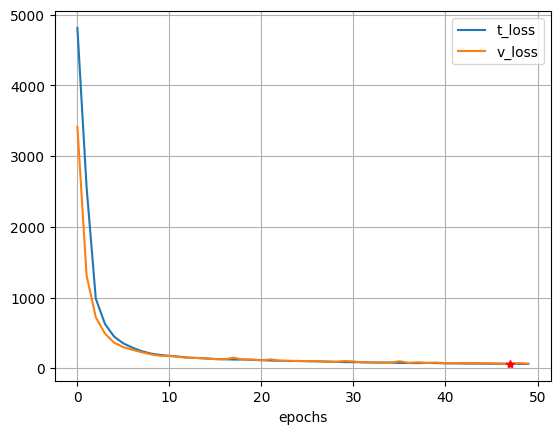

In [11]:
ep_opt = np.argmin(np.asarray(valloss))
plt.plot(trainloss, label='t_loss')
plt.plot(valloss, label='v_loss')
plt.plot(ep_opt, valloss[ep_opt], 'r*')
plt.grid('on')
plt.xlabel('epochs')
plt.legend()
print(f'best val_loss = {valloss[ep_opt]} at epoch = {ep_opt}')
plt.show()

wandb.log({"best_val_loss": valloss[ep_opt], "best_epoch": ep_opt})

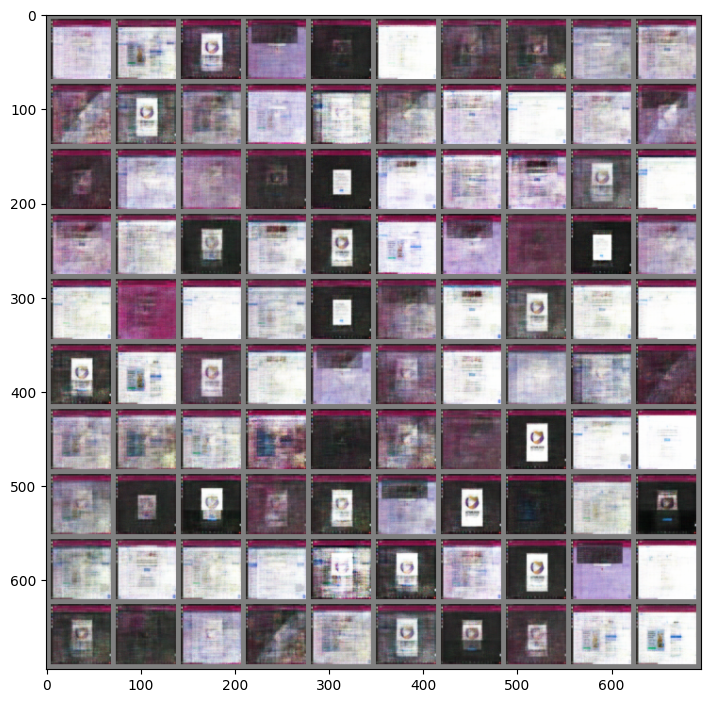

In [15]:
vae_best = Vae(latent_dims=d)
vae_best.to(device)
vae_best.load_state_dict(torch.load('best_vae_tosample.pt')['model_state_dict'])

vae_best.eval()
with torch.no_grad():
    latent = torch.randn(128, d, device=device)
    img_recon = vae_best.decoder(latent)
    img_recon = img_recon.cpu()
    mosaic = torchvision.utils.make_grid(img_recon.data[:100],10,5)
    fig, ax = plt.subplots(figsize=(20, 8.5))
    plt.imshow(unnormalized(mosaic))
    plt.show()

wandb.log({"decoded_random_latents": wandb.Image(unnormalized(mosaic))})

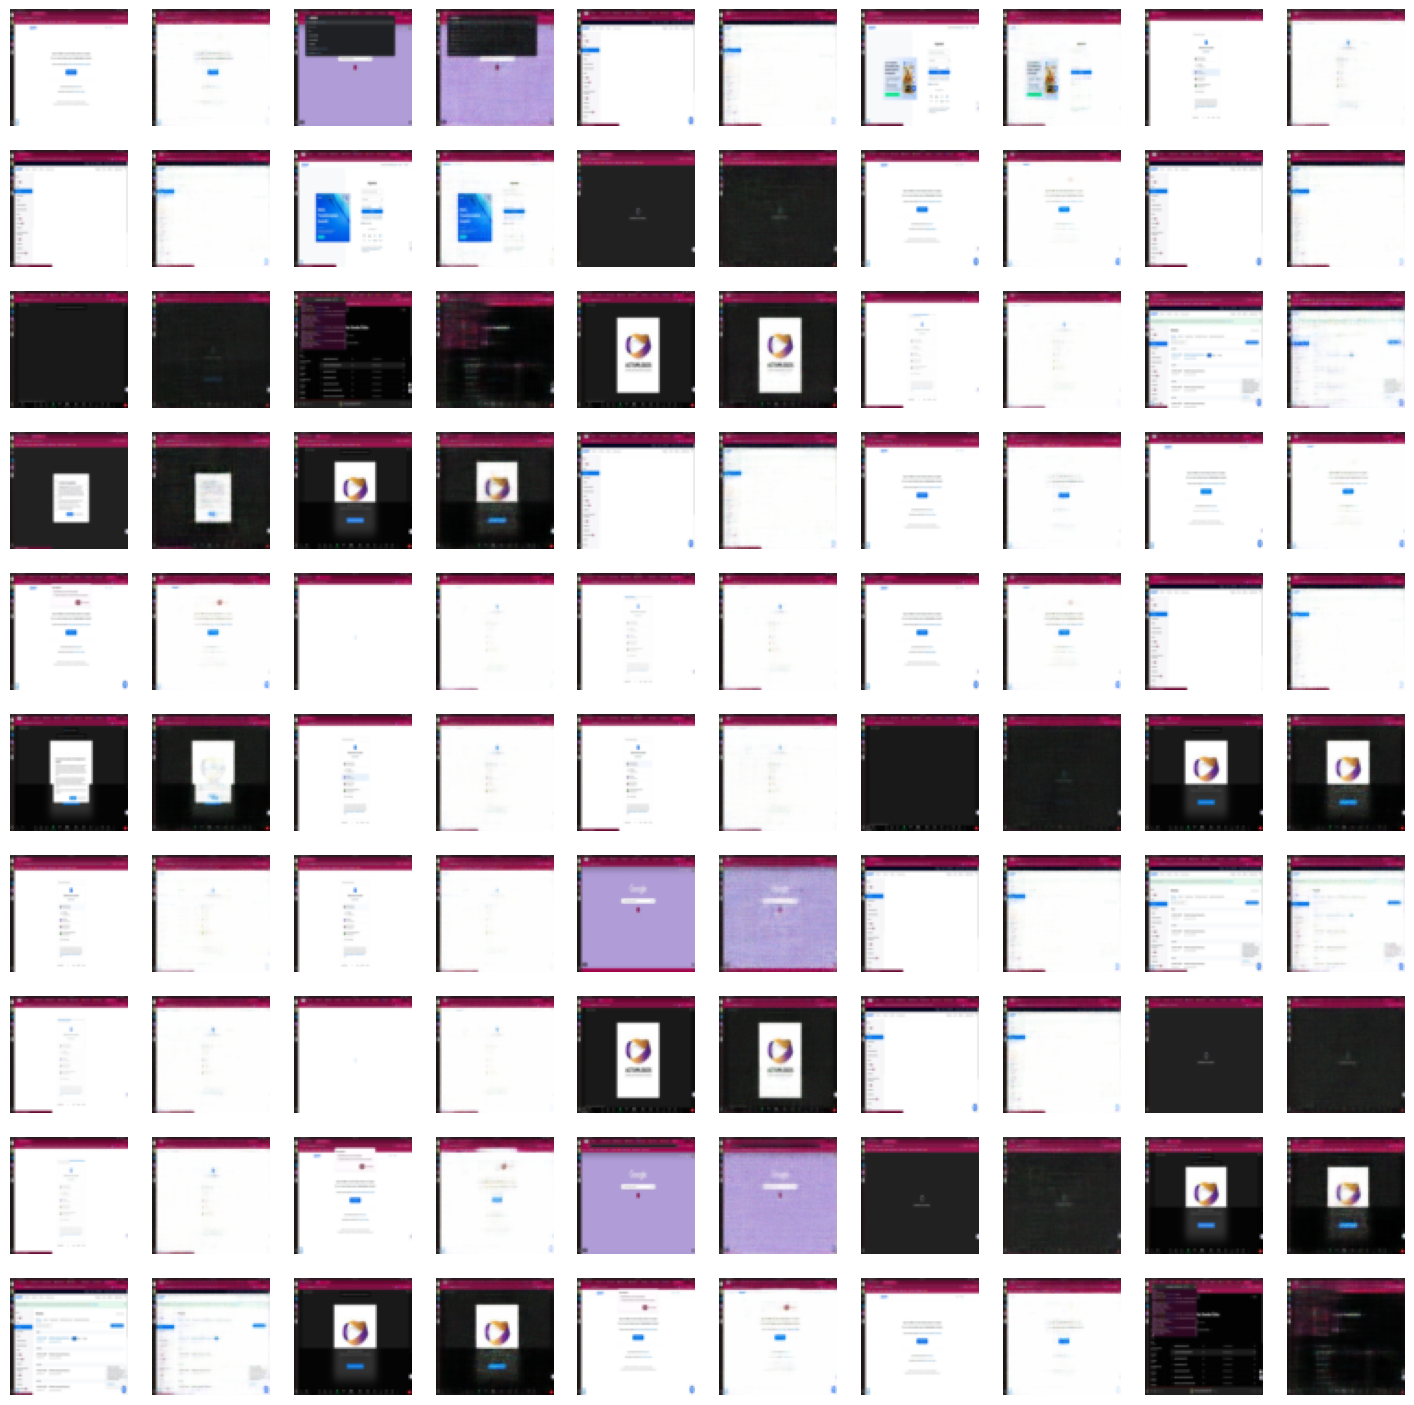

In [16]:
import matplotlib.pyplot as plt

xb = next(iter(valloader))
sample = list(np.random.randint(xb.shape[0], size=(50)))
vae_best.eval()
with torch.no_grad():
    x = xb[sample]
    z, _, _ = vae_best.encoder(x)
    y = vae_best.decoder(z)

plt.figure(figsize=(18,18))
for i in range(50):
    Y = unnormalized(y[i].cpu())
    X = unnormalized(x[i])
    plt.subplot(10,10,2*i+1)
    plt.imshow(X)
    plt.axis('off')
    plt.subplot(10,10,2*i+2)
    plt.imshow(Y)
    plt.axis('off')
plt.savefig("visual_validation.jpg")
plt.show()

wandb.log({"visual_validation": wandb.Image("visual_validation.jpg")})

In [15]:
# https://community.wandb.ai/t/taking-forever-to-finish-after-waiting-for-w-b-process-to-finish-success/4641/5
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


best_epoch,▁
best_val_loss,▁
t_loss,█▃▂▂▂▁▁▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▂▁▁▁
v_loss,█▃▂▂▂▁▁▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
best_epoch,1636
best_val_loss,15.59673
t_loss,17.50375
v_loss,17.23462
